In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
def save_notebook():
    return display(Javascript("IPython.notebook.save_notebook()"),
                   include=['application/javascript'])

def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [3]:
import sys, os
import glob
import warnings
from itertools import cycle
sys.path.append('../')

import ipywidgets as widgets

from rankutils.evaluation import comp_precision, comp_recall, interp_prec_recall_curve

from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
import mpld3
sns.set()

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange

markers = ['o', 'v', '^', 'D', 'P', '*', 'h', 'p', 'x']
pmarkers = cycle(['o', 'v', '^', 'D', 'P', '*', 'h', 'p', 'x'])

np.set_printoptions(suppress=True, precision=3, linewidth=300, formatter=dict(float="{0:0.4f}"))

In [4]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    if val < 0:
        color = 'red' 
    elif val > 0:
        color = 'blue'
    else:
        color = 'black'
    return 'color: %s' % color

In [5]:
def make_header_label(header):
    
    dataset = header['dataset']
    method = header['method']
    topn = header['topn']
    k = header['k']
    label = header['labelfolder']
    phi = header['phi']
    balance = header['balance']
    
    prefix = "{0:s} {1:s}".format(dataset, method)
    if len(str(method).split('_')) > 1:        
        label = "{0:25s} [{1:s}][n = {2:03d} | k = {3:03d} | phi = {4:0.2f}".format(prefix, label, topn, k, phi)
        if balance:
            label += " | b = {0:d}".format(balance)
        label += "]"
        
    else:
        label = "{0:15s} [n = {1:03d}]".format(prefix, topn)
    
    return label

In [6]:
def eval_elp_precision_recall(labels, k):
    
    assert labels.shape[1] >= k, "The number of positions labeled for each rank <{0:d}> should be >= k <{1:d}>".format(labels.shape[1], k)
    
    elp_rec = np.arange(0.0, 1.1, 0.1)
    elp_prec_all = []
    ap_all = np.zeros(labels.shape[0], dtype=np.float64)
    patk_all = np.zeros(labels.shape[0], dtype=np.float64)

    for i, row in enumerate(labels):
        
        y_true = row[0:k]
        
        if y_true.sum() > 0:

            prec = comp_precision(y_true)
            rec = comp_recall(y_true)

            elp_prec_all.append(interp_prec_recall_curve(prec, rec, points=elp_rec))

            ap_all[i] = average_precision_score(y_true, np.arange(y_true.size, 0, -1))
            patk_all[i] = np.mean(y_true)
        else:
            aux = np.zeros(11, dtype=np.float64)
            aux[0] = 1.0
            elp_prec_all.append(aux)

    elp_prec_all = np.vstack(elp_prec_all)

    mean_elp_prec = np.mean(elp_prec_all, axis=0)
    
    return mean_elp_prec, np.mean(ap_all), ap_all, np.mean(patk_all), patk_all

In [7]:
def load_pathlists(collection, get_bsl=[]):
    
    # Baseline Labels
    bsl_labeldir = '/home/alberto/phD/projects/performance_prediction/ret-mr-learning/input-labels/label.v2/{0:s}/'.format(collection)
    aux = glob.glob(bsl_labeldir + "*.npy")
    aux.sort()
    if get_bsl:
        bsl_labelpaths = []
        for i in get_bsl:
            bsl_labelpaths.append(aux[i])
    else:
        bsl_labelpaths = aux
    
    return bsl_labelpaths

In [8]:
topk_l = [30]
collection = 'places365'

calias = dict(oxford='Oxford', unicamp='Unicamp', corel='Corel', 
              places365='Places365', imagenet='Imagenet', vggfaces='VGGFace')

leg_name_map = dict()

np.set_printoptions(precision=3, suppress=True)

bsl_labelpaths = load_pathlists(collection)

In [9]:
# bsl_namelist = [[], []]
# bsl_eval = [[], []]

# min_mAP = np.inf
# max_mAP = -np.inf

# ap_all_list = []

# # Evaluating the baselines. Retains only the methods with max and min mAP
# for path in tqdm(bsl_labelpaths, desc="Evaluating baselines: ", total=len(bsl_labelpaths)):
    
#     mean_elp_prec, mAP, ap_all = eval_elp_precision_recall(np.load(path), topk)
#     ap_all_list.append(ap_all.reshape(-1, 1))
    
#     if mAP < min_mAP:
#         bsl_eval[0] = mean_elp_prec
#         aux = os.path.basename(path).rsplit('.', 2)[0]
#         bsl_namelist[0] = "{0:85s} : mAP = {1:0.3f} [MIN]".format(aux, mAP)
#         min_mAP = mAP
    
#     if mAP > max_mAP:
#         bsl_eval[1] = mean_elp_prec
#         aux = os.path.basename(path).rsplit('.', 2)[0]
#         bsl_namelist[1] = "{0:85s} : mAP = {1:0.3f} [MAX]".format(aux, mAP)
#         max_mAP = mAP

In [10]:
bsl_namelist = []
bsl_eval = []
bsl_ap_all = []
bsl_labels = []

for path in tqdm(bsl_labelpaths, desc="Evaluating baselines: ", total=len(bsl_labelpaths)):
    
    bsl_eval.append([])
    bsl_namelist.append([])
    bsl_ap_all.append([])
    bsl_labels.append(os.path.basename(path).rsplit('.', 2)[0])
    
    for k in tqdm(topk_l, desc="  For k", total=len(topk_l)):
        mean_elp_prec, mAP, ap_all, patk, patk_all = eval_elp_precision_recall(np.load(path), k)
        
        bsl_eval[-1].append(mean_elp_prec)
        bsl_ap_all[-1].append(ap_all)
        aux = os.path.basename(path).rsplit('.', 2)[0]
        bsl_namelist[-1].append("{0:35s} P@{1:d} = {2:0.3f} | mAP@{1:d} = {3:0.3f}".format(aux, k, patk, mAP))

In [11]:
colors = sns.choose_colorbrewer_palette('quantitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

['places365.001.vgg16-L2              P@30 = 0.351 | mAP@30 = 0.652']
['places365.002.resnet152-L2          P@30 = 0.316 | mAP@30 = 0.659']
['places365.003.vgg16-Cos             P@30 = 0.379 | mAP@30 = 0.671']


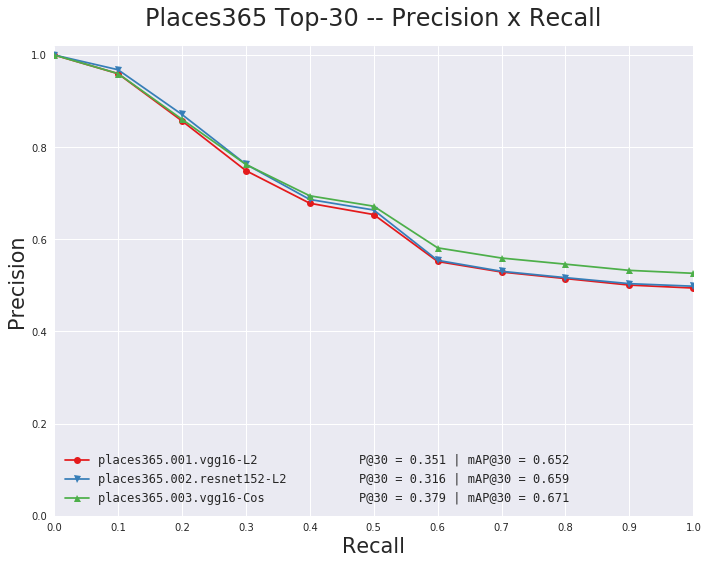

In [12]:
for n in bsl_namelist:
    print(n)

# changing the legend entry order
#order = [2, 0, 1, 3, 4, 5]
#order = [3, 0, 1, 2]
#order = range(len(agg_namelist))
    
fig, axes = plt.subplots(1)
try:
    axes = axes.reshape(-1)
except AttributeError:
    axes = [axes]
fig.set_size_inches(10, 8)


x = np.arange(0.0, 1.1, 0.1)

# Drawing Baselines

for j, k in enumerate(topk_l):
    for i in range(len(bsl_eval)):
        axes[j].plot(x, bsl_eval[i][j], marker=markers[i], color=colors[i], label="{0:s}".format(bsl_namelist[i][j]),
                alpha=1.0)

    axes[j].set_xlim(0.0, 1.0)
    axes[j].set_xlabel('Recall', **dict(fontsize='xx-large'))
    axes[j].set_xticks(np.arange(0.0, 1.1, 0.1))

    axes[j].set_ylim(0.0, 1.02)
    axes[j].set_ylabel('Precision', **dict(fontsize='xx-large'))

    #ax.grid(which='both', axis='both')

    axes[j].set_title('{0:s} Top-{1:d} -- Precision x Recall'.format(calias[collection], k), **dict(fontsize=24), pad=20)

    legend = axes[j].legend(prop={'family':'monospace', 'size':'medium'})

#plt.subplots_adjust(left=0.1, top=0.9, bottom=0.1)
fig.tight_layout()
#mpld3.enable_notebook()
plt.savefig('/home/alberto/phD/projects/performance_prediction/ret-mr-learning/results/thesis/retrieval/{0:s}_PxR.pdf'.format(collection, k))

1
3


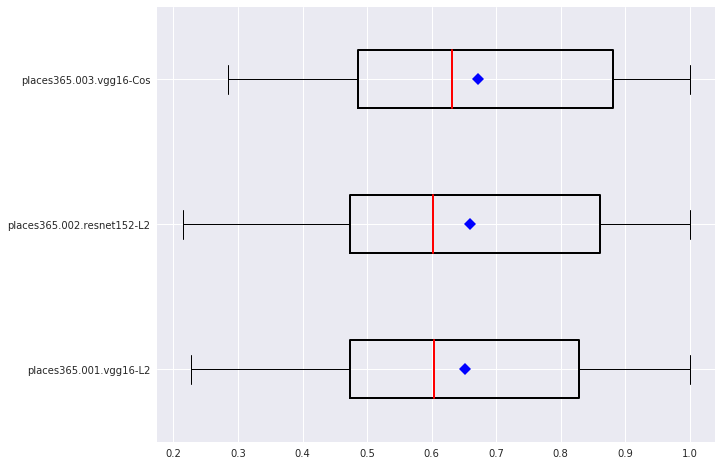

In [13]:
n = len(topk_l)

fig, axes = plt.subplots(n)
try:
    axes = axes.reshape(-1)
except AttributeError:
    axes = [axes]
fig.set_size_inches(10, 8)

print(len(bsl_ap_all[0]))
print(len(bsl_labels))

boxprops = dict(linewidth=2)
medianprops = dict(linewidth=2, color='red')
meanpointprops = dict(marker='D', markerfacecolor='blue', markersize=8)
for j, k in enumerate(topk_l):
    aux = [bsl_ap_all[i][j] for i in range(len(bsl_eval))]
    bplot = axes[j].boxplot(aux, labels=bsl_labels, vert=False, widths=0.4,
                    boxprops=boxprops, medianprops=medianprops, meanprops=meanpointprops, showmeans=True)